## sscws Conjunction Example Jupyter Notebook
This [notebook](https://jupyter.org) demonstrates using the [sscws](https://pypi.org/project/sscws/) to find satellite conjunctions.  Additionally, it demonstrates using [cdasws](https://pypi.org/project/cdasws) to get data from [cdaweb](https://cdaweb.gsfc.nasa.gov) for the satellite/ground stations involved in the conjunction.

### Prerequisites
For just satellite conjunctions, install the following module

In [12]:
#%pip install sscws

To also get data from cdaweb, install the following modules

In [13]:
#%pip install xarray
#%pip install cdflib
#%pip install cdasws

### Setup

In [14]:
import numpy as np
from sscws.sscws import SscWs
from sscws.conjunctions import BoxConjunctionArea, ConditionOperator,\
    GroundStationCondition, GroundStationConjunction,\
    Satellite, SatelliteCondition, TraceCoordinateSystem
from sscws.coordinates import CoordinateComponent, CoordinateSystem,\
    SurfaceGeographicCoordinates
from sscws.request import DataRequest, QueryRequest, SatelliteSpecification
from sscws.timeinterval import TimeInterval
from sscws.tracing import BFieldTraceDirection, TraceType
ssc = SscWs()

### Define Conjunction Query
Define a query to find magnetic field line conjuctions of at least two THEMIS satellites with one of four THEMIS ground stations during 2008 doy = 1 - 5.

In [15]:
sats = [
    Satellite('themisa', BFieldTraceDirection.SAME_HEMISPHERE),
    Satellite('themisb', BFieldTraceDirection.SAME_HEMISPHERE),
    Satellite('themisc', BFieldTraceDirection.SAME_HEMISPHERE),
    Satellite('themisd', BFieldTraceDirection.SAME_HEMISPHERE),
    Satellite('themise', BFieldTraceDirection.SAME_HEMISPHERE)
]
satellite_condition = SatelliteCondition(sats, 2)

box_conjunction_area = BoxConjunctionArea(TraceCoordinateSystem.GEO,
                                          3.00, 10.00)

ground_stations = [
    GroundStationConjunction('FSMI', 'THM_Fort Smith',\
        SurfaceGeographicCoordinates(59.98, -111.84),\
        box_conjunction_area),
    GroundStationConjunction('WHIT', 'THM_White Horse',\
        SurfaceGeographicCoordinates(61.01, -135.22),\
        box_conjunction_area),
    GroundStationConjunction('FSIM', 'THM_Fort Simpson',\
        SurfaceGeographicCoordinates(61.80, -121.20),\
        box_conjunction_area),
    GroundStationConjunction('GAK', 'THM_HAARP/Gakona',\
        SurfaceGeographicCoordinates(62.40, -145.20),\
        box_conjunction_area)
]
ground_station_condition = \
    GroundStationCondition(ground_stations,
                            TraceCoordinateSystem.GEO,
                            TraceType.B_FIELD)
conditions = [
    satellite_condition,
    ground_station_condition
]
query_request = \
    QueryRequest('Magnetic conjunction of at least 2 THEMIS satellites with one of 4 THEMIS ground stations during 2008 doy=1-5.',
                 TimeInterval('2008-01-05T10:00:00Z',
                              '2008-01-05T11:59:59Z'),
                 ConditionOperator.ALL,
                 conditions)


### Run Conjunction Query
Submit the conjunction query to [SSC](https://sscweb.gsfc.nasa.gov) for evaluation.

In [16]:
result = ssc.get_conjunctions(query_request)

### Display the results

In [17]:
SscWs.print_conjunction_result(result)

StatusCode: ResultStatusCode.SUCCESS StatusSubCode: ResultStatusSubCode.SUCCESS
2008-01-05T10:20:00+00:00 to 2008-01-05T10:34:00+00:00
  Satellite      Lat     Lon    Radius Ground Station           Lat     Lon    ArcLen
  themisd      -1.77  242.60  74817.00 THM_Fort Smith         58.86  253.08  81676.00
  themisd      -1.85  239.79  74618.00 THM_Fort Smith         59.22  251.14  82324.00
  themise      -1.50  238.10  75081.00 THM_Fort Smith         59.21  249.82  83264.00
  themise      -1.58  235.28  75153.00 THM_Fort Smith         59.59  247.82  84142.00
2008-01-05T10:35:00+00:00 to 2008-01-05T10:59:00+00:00
  Satellite      Lat     Lon    Radius Ground Station           Lat     Lon    ArcLen
  themisa       0.52  222.02  60857.00 THM_Fort Simpson       60.30  237.17  63709.00
  themisa       0.17  217.74  61674.00 THM_Fort Simpson       61.09  233.83  66012.00
  themisd      -1.85  239.58  74603.00 THM_Fort Smith         59.23  251.00  82357.00
  themisd      -1.98  234.76  74165.

---
### Setup For Access To CDAWeb Data
The following is code to find the corresponding data from [cdaweb](https://cdaweb.gsfc.nasa.gov/).  Note that you need to have installed CDF, spacepy, and cdasws as mentioned in [prerequisites](#Prerequisites) for the following.

In [18]:
import re
from cdasws import CdasWs
from cdasws.datarepresentation import DataRepresentation
import matplotlib.pyplot as plt
cdas = CdasWs()
gs_id = {
    'THM_Fort Smith': 'FSMI',
    'THM_White Horse': 'WHIT',
    'THM_Fort Simpson': 'FSIM',
    'THM_HAARP/Gakona': 'GAK'
}

def get_cdaweb_ds(name: str) -> str:
    if name.startswith("THM"):
        return 'THG_L2_MAG_' + gs_id[name]
    else:
        return 'TH' + name[-1].upper() + '_L2_FGM'

def get_a_mag_var_name(ds: str, names) -> str:
    match = re.search('^THG_L2_MAG_(\w*)$', ds)
    if match:
        station = match.group(1)
        return 'thg_mag_' + station.lower()
    else:
        for name in names:
            if name.endswith('fgs_btotal'):
                return name
    return None

### Get Data During Conjunction
Get data from cdaweb during the conjunctions and plot it.

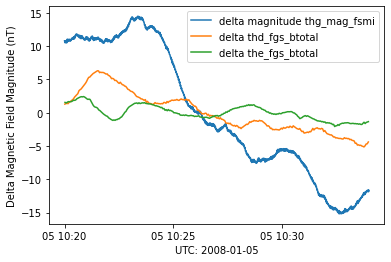

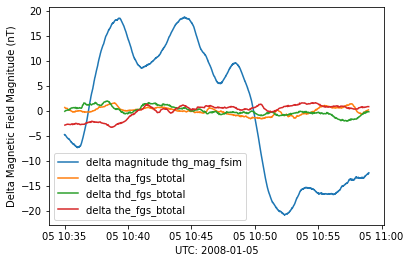

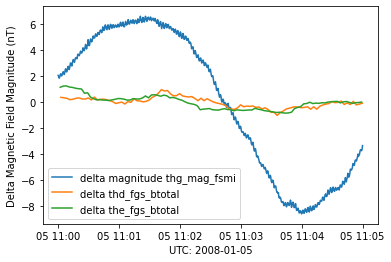

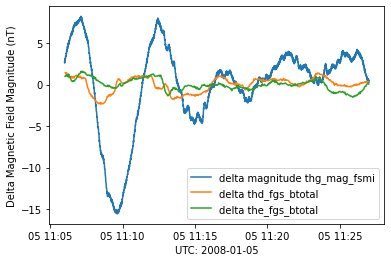

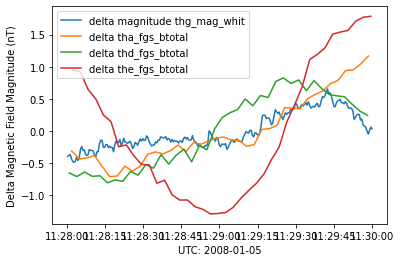

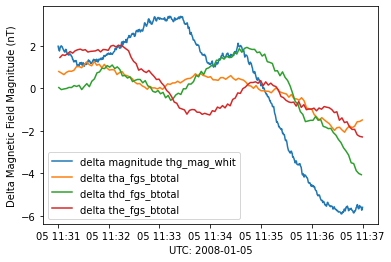

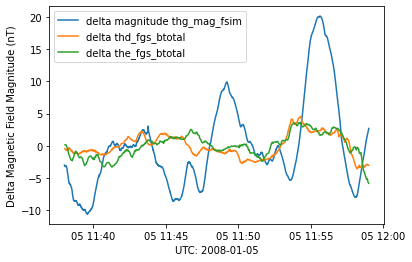

In [19]:
for conjunction in result['Conjunction']:
    time_interval = conjunction['TimeInterval']
    start = time_interval['Start']
    end = time_interval['End']
    sats = []
    for sat_des in conjunction['SatelliteDescription']:
        sats.append(sat_des['Satellite'])
    sat = conjunction['SatelliteDescription'][0]['Satellite']
    gs = conjunction['SatelliteDescription'][0]['Description'][0]['TraceDescription']['Target']['GroundStation']
    datasets = [get_cdaweb_ds(gs)]
    for sat in sats:
        datasets.append(get_cdaweb_ds(sat))
    for ds in datasets:
        var_name = get_a_mag_var_name(ds, cdas.get_variable_names(ds))
        status, data = cdas.get_data(ds, [var_name], start, end,
                                     dataRepresentation = DataRepresentation.XARRAY)
        var_data = data[var_name]
        epoch_var_name = var_data.attrs['DEPEND_0']
        if var_data.ndim == 2:
            var_data = np.linalg.norm(var_data, axis = 1)
            data_label = 'delta magnitude ' + var_name
        else:
            data_label = 'delta ' + var_name
        mean = var_data.mean(axis = 0)
        delta_data = var_data - mean
        plt.plot(data[epoch_var_name], delta_data, label = data_label)

    plt.xlabel('UTC: ' + start.date().isoformat())
    plt.ylabel('Delta Magnetic Field Magnitude (nT)')
    plt.legend()
    plt.show()

### Additional Documentation
View the [sscws API](https://sscweb.gsfc.nasa.gov/WebServices/REST/py/sscws/) for additional features.